# Evaluation by BigML 

Check Install and launch BigML ; 
for help : https://bigml.readthedocs.io/en/latest/index.html#local-predictions ; 
Use this link to retreive the key with your account :  https://bigml.com/account/apikey

In [12]:
import bigml.api
from bigml.api import BigML
api = BigML('ALEXISD', '8fe5e17917b5a9ef7a0ec327a53c3f1d507f0911', project='project/5d94a45aeba31d46690001d3')

Building Source

In [13]:
source = api.create_source('cs-training.csv')
api.ok(source)

True

Building Dataset

In [14]:
dataset = api.create_dataset(source)
api.ok(dataset) 

True

Random Split Building dataset into 80% train and 20% Validation

In [15]:
train_dataset = api.create_dataset(dataset, {"name": "train", "sample_rate": 0.8, "seed": "my seed"})
api.ok(train_dataset)
validation_dataset = api.create_dataset(dataset, {"name": "validation", "sample_rate": 0.8, "seed": "my seed", "out_of_bag": True})
api.ok(validation_dataset)

True

Building model

In [16]:
ensemble = api.create_ensemble(train_dataset)
api.ok(ensemble)

True

Building evaluation and print evaluation

In [17]:
evaluation = api.create_evaluation(ensemble,validation_dataset)
api.ok (evaluation)

True

Print

In [18]:
api.pprint(evaluation['object']['result'])

{   'mean': {   'mean_absolute_error': 0.89952,
                'mean_squared_error': 1.2345,
                'r_squared': 0},
    'model': {   'mean_absolute_error': 0.75886,
                 'mean_squared_error': 1.00047,
                 'per_class_statistics': [],
                 'r_squared': 0.18958},
    'random': {   'mean_absolute_error': 9.36501,
                  'mean_squared_error': 120.54517,
                  'r_squared': -96.64727}}


In [15]:
api.pprint(evaluation['object']['result']['model']['accuracy'])
api.pprint(evaluation['object']['result']['model']['average_area_under_roc_curve'])
api.pprint(evaluation['object']['result']['model']['confusion_matrix'])


KeyError: 'accuracy'

In [19]:
batch_prediction = api.create_batch_prediction(ensemble, validation_dataset, {"name": "my val predction", "all_fields":True, "header":True,"probabilities":True})
api.ok(batch_prediction)
api.download_batch_prediction(batch_prediction,filename='my_predictions_val.csv')

'my_predictions_val.csv'

# Confusion Matrix by Pandas

In [1]:
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
df_val = read_csv('my_predictions_val.csv')


In [2]:
def CalculError_seuil2 (row):
    v = row['SeriousDlqin2yrs']
    w = row['1 probability']
    s1 = row['seuil']
    if v == 0 :
        if w < s1 :
            return 'TN'
        else :
            return 'FP'
    else :
        if w < s1 :
            return 'FN'
        else :
            return 'TP'

In [3]:
def calcul_gain (s,PL0_0,PL0_1,PL1_0,PL1_1,option): 
    df_val['seuil'] = s
    df_val['error']= df_val.apply (CalculError_seuil2, axis = 1)
    resultat = df_val.groupby('error')['field1'].nunique()
    df_matrixConfusion = pd.DataFrame({'Prediction 0' : [resultat[2],resultat[0]], 'Prediction 1':[resultat[1],resultat[3]]},index = ['Actual 0', 'Actual 1'] )
    df_matrixCost = pd.DataFrame({'Prediction 0' : [PL0_0,PL1_0], 'Prediction 1':[PL0_1, PL1_1]},index = ['Actual 0', 'Actual 1'] )
    total_gain = df_matrixCost * df_matrixConfusion
    total_gain2 = total_gain.sum (axis = 1)
    total_gain3 = total_gain2.sum (axis = 0)
    
    switcher={
                1: resultat,
                2: df_matrixConfusion,
                3: df_matrixCost,
                4: total_gain3
            }
    return switcher.get(option,"Invalid option")
    

In [4]:
#COST Matrix
PL0_0 = 500
PL1_0 = -2500
PL0_1 = -500
PL1_1 = 0

#Precison
P = 100


**** Pour un seuil = 0.5 ****
error
FN     1686
FP      236
TN    27749
TP      329
Name: field1, dtype: int64

** Matrice de confusion
          Prediction 0  Prediction 1
Actual 0         27749           236
Actual 1          1686           329

** Matrice de cout
          Prediction 0  Prediction 1
Actual 0           500          -500
Actual 1         -2500             0

 => Le P&L est de 9541500 au seuil de 0.5

**** Simulation ****
=> Le P&L maximum est de 9989500 au seuil de 0.29


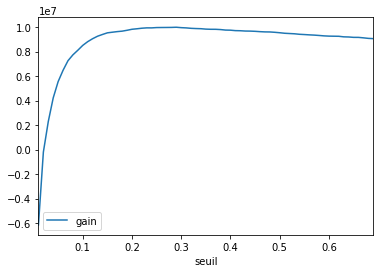

In [5]:
#df_val.info()

res = calcul_gain (0.5,PL0_0,PL0_1,PL1_0,PL1_1,1)
mtxcf = calcul_gain (0.5,PL0_0,PL0_1,PL1_0,PL1_1,2)
mtxct = calcul_gain (0.5,PL0_0,PL0_1,PL1_0,PL1_1,3)
pl05 = calcul_gain (0.5,PL0_0,PL0_1,PL1_0,PL1_1,4)

print()
print ('**** Pour un seuil = 0.5 ****')
print (res)
print()
print ('** Matrice de confusion')
print (mtxcf)
print()
print ('** Matrice de cout')
print (mtxct)
print()
print (f' => Le P&L est de {pl05} au seuil de 0.5')

print()
print ('**** Simulation ****')

dfx = pd.concat([pd.DataFrame({'seuil': [i/P],
                                       'gain' : [calcul_gain(i/P,PL0_0,PL0_1,PL1_0,PL1_1,4)]}) 
                                        for i in range (1,int(7*P/10))], ignore_index=True)

dfx_max = dfx[dfx['gain'] == dfx['gain'].max()]
idx_max = dfx_max.index[0]
seuil_max = dfx_max.at[idx_max,'seuil']
gain_max = dfx_max.at[idx_max,'gain']
print (f'=> Le P&L maximum est de {gain_max} au seuil de {seuil_max}')
dfx.plot(x='seuil' , y='gain')

In [8]:
mask_positives = (df_val.SeriousDlqin2yrs==1)
mask_negatives = (df_val.SeriousDlqin2yrs==0)
positives = df_val[mask_positives]
negatives = df_val[mask_negatives]

c = 0
n = positives.shape[0] * negatives.shape[0]
for proba_positive in positives['1 probability']:
    count = negatives[ negatives['1 probability'] < proba_positive ].shape[0]
    c = c+count

auc = c/n
print(auc)

0.8545627110588755


In [1]:
from bigml.api import BigML
import matplotlib.pyplot as plt

api = BigML('ALEXISD', '8fe5e17917b5a9ef7a0ec327a53c3f1d507f0911', project='project/5d94a45aeba31d46690001d3')
#api = BigML(project='project/5d94a45aeba31d46690001d3')

source_train = api.create_source('https://oml-data.s3.amazonaws.com/kaggle-give-me-credit-train.csv')


# On crée un dataset à partir de la source puis on split (Val et Test)

train_full = api.create_dataset(source_train, {"name": "Train Full"})
val_set = api.create_dataset(train_full, {"name": "Val_set", "sample_rate": 0.8, "seed": "my seed"})
test_set = api.create_dataset(train_full, {"name": "Test_set", "sample_rate": 0.8 , "seed": "my seed", "out_of_bag": True})

# creation des listes vides pour contenir l'abscisse (taille du dataset) et l'ordonnée (AUC) pour le modele ensemble et deepnet

x_ensemble = []
y_ensemble = []
x_deepnet = []
y_deepnet = []

for i in range(1,11): # On fait une boucle pour faire varier de 10 à 100 % de lignes du dataset Val_set
   
    # On crée le nouveau dataset de train à partir du dataset de train initial
    train_set = api.create_dataset(val_set, {"name": "Train Set " + str(i/10), "sample_rate": i/10, "seed": "my seed"})
    api.ok(val_set)   
   
    # On crée le modèle (ensemble) à partir du train_set
    ensemble = api.create_ensemble(train_set, {"objective_field" : "SeriousDlqin2yrs", "name": "Ensemble " + str(i/10)})
    api.ok(ensemble)
   
    # On évalue le modèle ensemble (avec le test_set)
    evaluation = api.create_evaluation(ensemble, test_set)
    api.ok(evaluation)
   
    # On crée le modèle (deepnet) à partir du train_set
    deepnet = api.create_deepnet(train_set, {"objective_field" : "SeriousDlqin2yrs", "name": "Deepnet " + str(i/10)})
    api.ok(deepnet)
   
    # On évalue le modèle deepnet (avec le test_set)
    evaluation_deepnet = api.create_evaluation(deepnet, test_set)
    api.ok(evaluation_deepnet)

    # On stocke dans une liste la valeur de l'axe des abscisses (graph_x) et la valeur de l'AUC (graph_y) à partir de la donnée BigML
    x_ensemble.append(i*10)
    y_ensemble.append(evaluation['object']['result']['model']['average_area_under_roc_curve'])
    
    x_deepnet.append(i*10)
    y_deepnet.append(evaluation_deepnet['object']['result']['model']['average_area_under_roc_curve'])
    
    # On itere de 1 le compteur i et on recommence la boucle
    i += 1

# On imprime les resultats
    
print(x_ensemble)
print(y_ensemble)
print(x_deepnet)
print(y_deepnet)



[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[0.83114, 0.84526, 0.84648, 0.85022, 0.85199, 0.85267, 0.85297, 0.85368, 0.85429, 0.85502]
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[0.81831, 0.8223, 0.83525, 0.82907, 0.83155, 0.82001, 0.82901, 0.82621, 0.83725, 0.83556]


<Figure size 640x480 with 1 Axes>

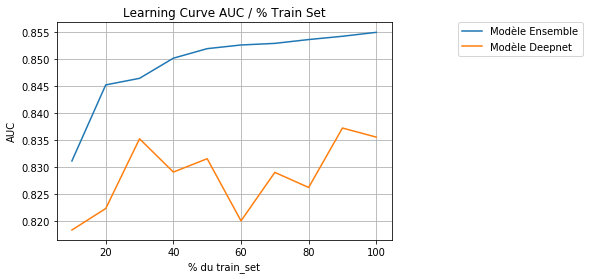

In [2]:

# On cree le graphique du modele deepnet et ensemble (AUC en fonction de la taille du dataset)

fig, ax = plt.subplots()
ax.plot(x_ensemble, y_ensemble, label='Modèle Ensemble')
ax.plot(x_deepnet, y_deepnet, label='Modèle Deepnet')
ax.set(xlabel='% du train_set', ylabel='AUC',  title='Learning Curve AUC / % Train Set')
plt.legend(bbox_to_anchor=(1.2, 1), loc='best', borderaxespad=0.)
ax.grid()
plt.show()

# PREDICTION by BigML

Building Source for TEST

In [11]:
source_Test = api.create_source('Test_New1.csv')
api.ok(source_Test)

NameError: name 'api' is not defined

Building Dataset for TEST

In [ ]:
dataset_Test = api.create_dataset(source_Test)
api.ok(dataset_Test) 

True

Building model

In [ ]:
ensemble = api.create_ensemble(dataset)
api.ok(ensemble)

True

Batch Prediction on Test


In [ ]:
batch_prediction = api.create_batch_prediction(ensemble, dataset_Test, {"name": "my batch predction", "all_fields":True, "header":True,"probabilities":True})
api.ok(batch_prediction)

True

downloading the results to your computer

In [ ]:
api.download_batch_prediction(batch_prediction,filename='my_predictions.csv')

'my_predictions.csv'